In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, multivariate_normal, norm
from scipy.optimize import minimize
import copy, os
from IPython.display import Image, display
from tutorialObjs import World, UserModel, Assistant, exp_normalize, run_task

# Collaborative modelling, design and decision making with AI, Part II <a class="anchor" id="title"></a>

Elena Shaw, Ali Khoshvishkaie, Sebastiaan De Peuter, Alex Hämäläinen, Samuel Kaski

When doing research with Machine Learning, it's helpful to be able to separate the problems that have been solved from the problems you will need to solve for yourself. In our goal to help other researchers leverage the AI-assistance framework for their own research problems, we're developing this tutorial as a quick, hands-on introduction to the problem landscape. 

AI assistance encompasses any task, game, or problem involving a human and an AI agent that is tasked with helping the human navigate the dynamics of the task. The motivation is that the AI's help can make solving the task more efficient and less burdensome to the human. In practice, this can be achieved by helping the human by filtering out less efficient solutions, minimizing human error, steering focus away from distractions etc. 

Due to the introductory nature of this tutorial, we will make use of existing solutions without too much explanation of their details. Interested researchers can consider the additional resources provided to develop more depth on the relevant topics. In this tutorial, however, we focus on guiding you through implementing the key components of the framework you would need to specify according to your research problem.

## Easy Navigation
* [Introduction](#intro)
* [1) The World](#world)
* [2) The Assistant](#ai)
    * [Task 1: Implement user model](#task1)
    <!--     * [Task 1 part i](#task_11)
        * [Task 1 part ii](#task_12)
        * [Task 1 part iii](#task_13) -->
    * [Task 2: Implement param inference](#task2)
    <!--     * [Case study i: "all coins display tails"](#task_21)
        * [Case study ii: at least "1 coin display tails" ](#task_22)
        * [(Bonus) Case study iii: "Exactly 1 tail"  ](#task_23) -->
* [3) The AI-user interaction](#intxn)
    * [Task 3: Implement interaction loop](#task3)
    <!--     * [Task 3 part i](#task_31)
        * [(Optional) Task 3 part ii](#task_32)
        * [Task 3 part iii](#task_33)
            * [Plot by mean/SD value](#task_33_abs)
            * [Plot by RMSE](#task_33_rmse) -->
* [Conclusions](#analysis)

# Introduction <a class="anchor" id="intro"></a>

AI-assistance is fundamentally a sequential decision-making problem, in which the AI-assistant continually advises an action in the world and the user takes the ultimate decision based on the AI's advice, their understanding of the world, and personal goals. The AI-assistant needs to infer the goals of the user based on the actions they make, and as a result, learn to make better, more relevant recommendations to the user.

The figure below illustrates the key elements that make up the AI-assistance framework. This tutorial will walk you through a simple implementation on a few of them.

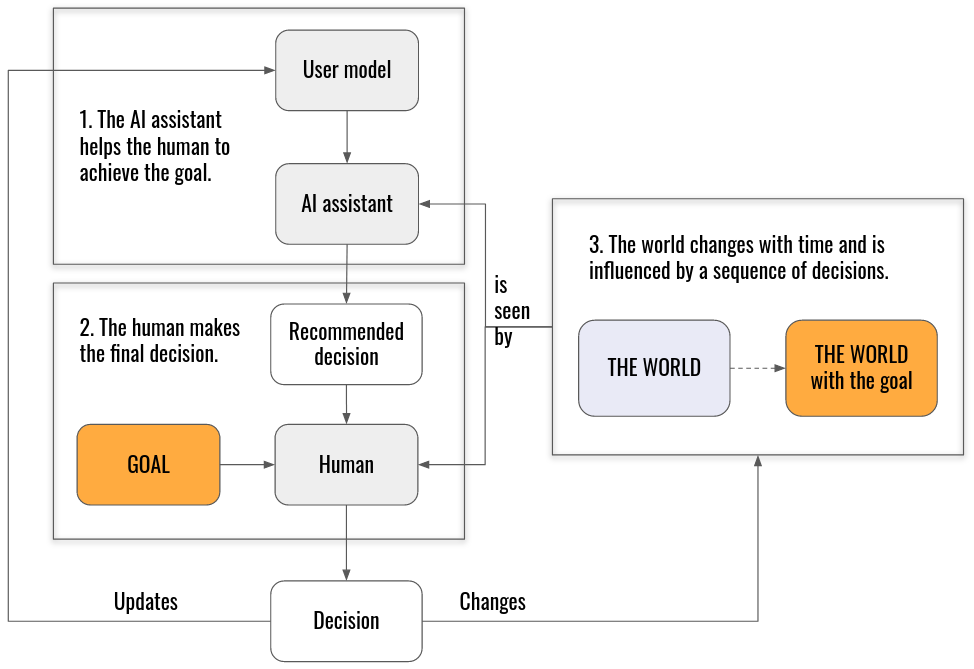

In [2]:
Image('ai-assistance-overview.png')


We'll introduce the key concepts of this framework through an illustrative journey planning problem. The task here is fundamentally a multi-objective optimization problem: an anonymous user wants to travel from city A to city B via a personalized journey itinerary catering to their travel preferences. 

**The Task:** Given that the AI assistant has never encountered this user before, how should it learn the optimal personalized recommendations for the user?

# 1) Defining the world <a class="anchor" id="world"></a>

As a first step towards solving the problem of interest, let's begin by defining the environment. 

Consider there are 10 locations involved, 2 are accounted for based on where the journey should begin and end, then 8 are possible layover or transition locations situated in between. We arbitrarily define the start location to be number 7 and the end location to be 5. If you run the cell below which plots the task, you'll see that these two nodes have a darkened center to distinguish them from the rest.

Starting point: 7
Destination: 5


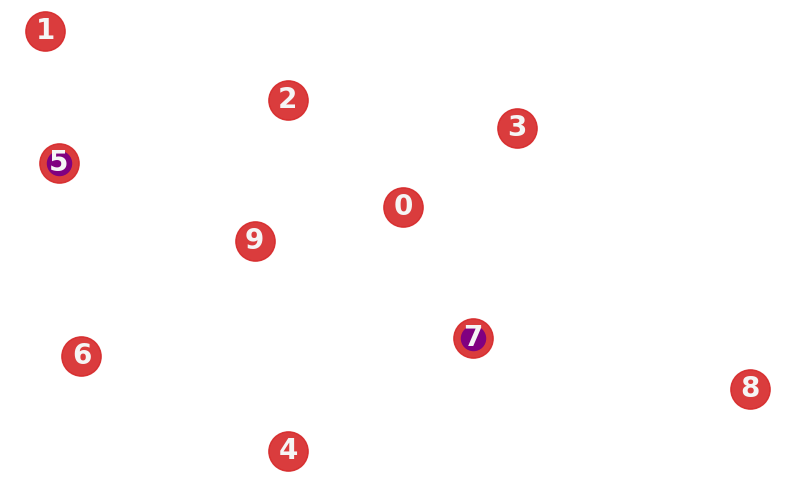

In [5]:
task = World()
print("Starting point:", task.start)
print("Destination:", task.destination)
plt.figure(figsize=(10,6))
task.display_path()

Each of these 10 locations are connected to others via several different transportation modes (e.g. train, ferry, plane, bus). Here, we'll let there be 5 different transportation mode, each represented by a graph $G_i=(V, E_i)$ where $V$ are the (set of) locations and $E_i$ are the edges connecting the locations via transportation mode $i$. The cell below visualizes these transportation mode graphs.

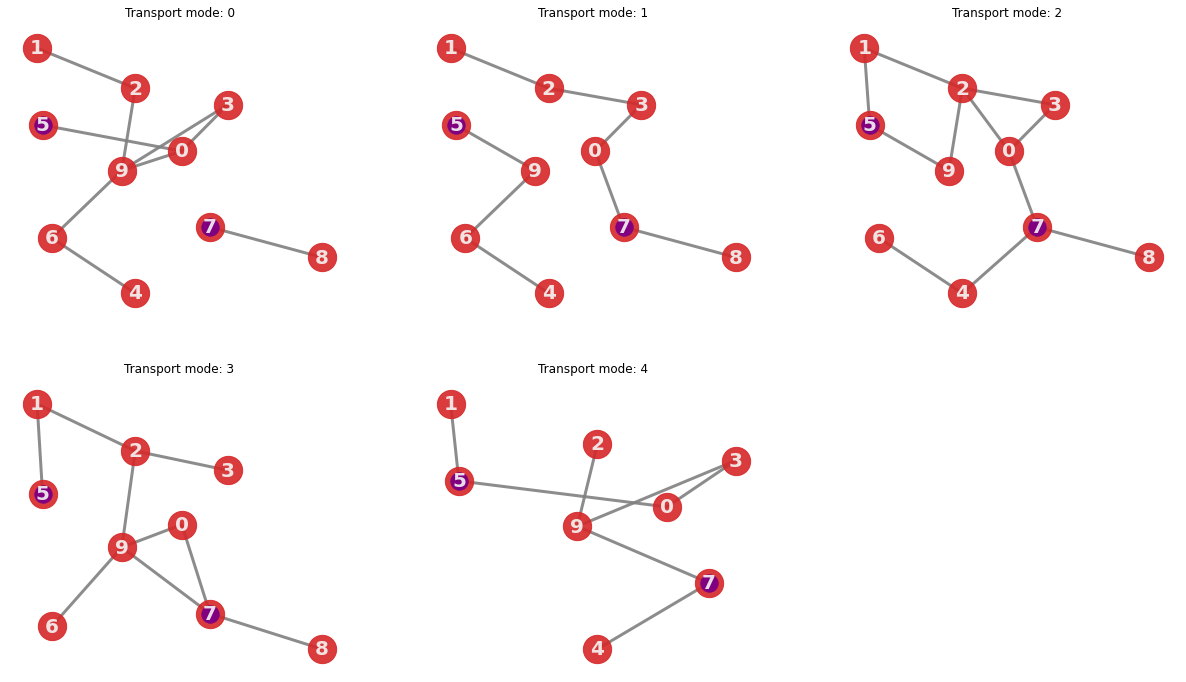

In [6]:
task.display()

Different modes of transport will incur different costs. For example, shown in the cell below, taking mode 3 (e.g. a flight) between locations 1 and 2, $e^{12}_3 \in E_3$, will be more expensive than traveling the same route via mode 2 (e.g. a bus), $e^{12}_2 \in E_2$. The multiobjective trade off is that the more expensive journey via mode 3 will result in a shorter travel time than the journey via mode 2. 

For our task, each edge will have 3 properties which accumulate linearly if the user travels along that edge: travel distance, travel price, and travel time.

In [7]:
mode3_properties = task.look_up_cost((1,2,3))
print("Travel 1 to 2 by mode 3...")
print(f'\t Travel distance: {mode3_properties[0]} \n'
      f'\t Travel price: {mode3_properties[1]} \n'
      f'\t Travel time: {mode3_properties[2]} \n')

mode2_properties = task.look_up_cost((1,2,2))
print("Travel 1 to 2 by mode 2...")
print(f'\t Travel distance: {mode2_properties[0]} \n'
      f'\t Travel price: {mode2_properties[1]} \n'
      f'\t Travel time: {mode2_properties[2]} \n')


Travel 1 to 2 by mode 3...
	 Travel distance: 1.1775637768585232 
	 Travel price: 7.1532351797160425 
	 Travel time: 9.122601945891402 

Travel 1 to 2 by mode 2...
	 Travel distance: 1.1228275760101307 
	 Travel price: 4.417607185194154 
	 Travel time: 17.144224062849656 



# 2) The Assistant <a class="anchor" id="ai"></a>

## The User model

AI-assistants are designed to help its users in a complementary way: provide advice and perspectives the user alone may not have access to. To do this effectively, the AI must understand the task in relation to the human; it must  define the problem as a task the *human* wishes to solve. It is not uncommon to frame the user task as a type of game, where there is a specific goal that the human agents is working toward. For AI-assistance, rather than being a single player game, the task can be modeled within an environment, where the user and AI agent cooperate to reach the goal. Often, these can be framed as decision problems: MDP, POMDPs, etc.

In order for an AI assistant to be helpful to and cooperate with the human, it must have a way of learning about the human. Our framework does this with user models, where the AI learns and maintains a model of the human user. This is not unlike our own human behavior: when interacting with other humans, we develop mental models of the other person. And over time, by learning more about them, we leverage those models to infer other's goals and to predict how interactions with them may play out. Think about how you've undoubtedly held the door open for someone who was carrying something with both hands. This requires inferring that the person wanted to walk through the door in the first place, and predicting how the situation would change if you held the door open for them. We replicate this same concept for an AI agent through a user model. By maintaining a model of the user, the AI better plans and more efficiently cooperates with the user based on the inferred preferences and biases of the user.

*(If you want a more complete overview of user models and how to define them, see slides _ to __ in the presentation deck.)*

In our task, the user must navigate through a large space of potentially optimal decisions -- journey paths offering the best trade off according to individual preferences. This trade off is not known *a priori* and even if the relevant information to make this decision is available, it cannot be processed and filtered all at once. 

For this tutorial, we model this behavior under bounded rationality theory. 

### Boundedly rational behavior:
A bounded rational agent simulates human's limited cognitive ability to rationally process all available options at once. Here, due to the sheer number of available options, the user is unable to identify which journey from location 7 to 5 would be their most preferred. However, when presented with a limited subset of options, the user will have a strong preference based on the hidden preference parameter $\boldsymbol{\beta}^*$.

To illustrate this, consider the world state below. The colors correspond to different transportation modes, but more importantly, note the solid versus dotted paths between locations 7 and 5. The dotted path is the journey itinerary suggested by the AI-assistance, while the solid path denotes the user's preferred itinerary. The cognitive limitation illustrated here is that the user's preferred path cannot and will not be any arbitrary (valid) path between 7 and 5. Instead, the user's actioned preference is limited to journeys that are close to the AI's original suggestion. 

*(The implementation details are not necessary to know for this tutorial, but if you feel you need to reference the details of our implementation, the relevant code can be found in the `self._find_alternatives()` method of the `User` object in `tutorialObjs.py`)*

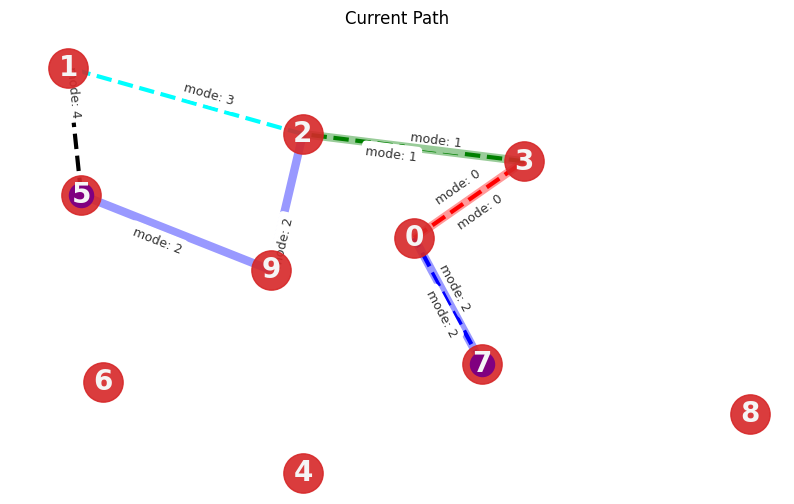

In [6]:
# AI makes a recommendation
ai_advice = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]
task.step(ai_action=ai_advice)

# User responds with a counter proposal based on hidden preferences
user_action = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 9, 2), (9, 5, 2)]
task.step(user_action=user_action)

plt.figure(figsize=(10,6))
task.display_path()

## The assistant agent

Given the components implemented above, you are now ready to implement your own AI-assistant. Below we've provided you with incomplete code for your AI-assistant. You will need to complete the two tasks below before your AI is functional.

## Task 1: Implement the user model <a class="anchor" id="task1"></a>

Consider the anonymous user who will have hidden preferences for how they weight the tradeoff among the available transportation modes for each $E_i$ of their journey. 

### Boltzmann model of rationality **[Insert information about Boltzmann Rationality here]**

We will model this tradeoff using the Boltzmann model of rationality. Namely, that users are likely to take an action based on a policy of maximized utility across all possible actions $a_t$ at time $t$:
$$
\text{Pr}(a_i|\boldsymbol{\beta}) \propto \exp \Big \{ \boldsymbol{\beta} \cdot \text{Utility}(a_i) \Big \}
$$
where $\boldsymbol{\beta}$ is the user specific parameter vector.

For ease of interpretation, we will leverage the inverse of this model in this tutorial, i.e. that the anonymous user will seek to minimize the total cost of the journey. The costs associated with each segment of the journey will play into the user's overall preference for any given journey, so you can interpret $\boldsymbol{\beta}$ as weight parameters on the edge properties. 

<!-- We will let $\boldsymbol{\beta}^*$ denote the anonymous user's hidden but true parameter that the AI will want to learn.  -->

So, to travel by mode $i$ along edge $e^{j}_{i} = (d^{j}_{i},p^{j}_{i},t^{j}_{i}) \in E_i$ with distance $d^{j}_{i}$, price $p^{j}_{i}$, and time $t^{j}_{i}$, a user will weigh their preference $\boldsymbol{\beta}$ as a linear combination:

$$
{\boldsymbol{\beta}}^{\intercal} e^{j}_{i} = \beta_0 d^{j}_{i} + \beta_1 p^{j}_{i} + \beta_2 t^{j}_{i}, \quad \boldsymbol{\beta} = 
\begin{bmatrix}
\beta_0\\
\beta_1\\
\beta_2\\
\end{bmatrix}
$$


In [ ]:
def boltzmann_policy(all_paths,beta):
    """
    Args:
      all_paths (type `list(tuple)`): 
          The list of valid paths being considered by the user.
          
          Example: [[(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)],
                    [(7, 0, 3), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)],
                    [(7, 0, 4), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)]]
          
      beta (type `numpy.array`):
          The vector of the user's hidden preference parameter.
          
          Example: np.array([0.05, 0.3, 0.65])

    Returns:
      tuple(all_paths, action_probabilities)
      
      all_paths (type `list`): 
          Same as the input.
          
      path_probabilities (type `list(numeric)` or `numpy.array`): 
          The probabilities (pmf) of selecting the corresponding path as calculated
          according to Boltzmann rationality. Note that this must be normalized
          to sum to 1, so that it is a proper distribution.
          
          Example: [.5,.2,.3] or np.array([.5,.2,.3])
    """    
    all_costs =[]
    for path in all_paths:
        path_properties = np.array([task.look_up_cost(edge) for edge in path])
        
        raise NotImplementedError("User model has not been implemented")
#TODO: Replace _ with the Boltzmann user model 
        path_costs = [_ for p in path_properties]
        
        journey_cost = np.sum(path_costs)
        all_costs.append(journey_cost)

    path_probabilities = exp_normalize(all_costs)
        
    return all_paths, path_probabilities

In [ ]:
# run this cell to test if your function behaves correctly
test_params = np.array([1,1,1])
test_paths = [[(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)],
              [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 3)],
              [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]]
expected_probs = np.array([1,1,1])/3
paths, probs = boltzmann_policy(test_paths,test_params)

assert paths == test_paths, f"output actions {paths} don't match the input actions {test_paths}"
assert np.allclose(probs,expected_probs), f"expected:{expected_probs}, got:{probs}"

## Task 2: Implement the user inference <a class="anchor" id="task2"></a>

Every action the anonymous user makes informs the AI of their preference. As such, given the observed action the user takes, the AI should infer the parameters which motivated the observed decision. Under Boltzmann rationality, this means inferring that the observed action is most likely the one which minimizes cost (or, more formally, maximizes utility). Many statistical methods exist for inference, but for the purposes of this tutorial, we will use the Bayesian method of posterior update via the LaPlace Approximation.

Assume that the parameters $\boldsymbol{\beta}$ come from a Gaussian distribution. We know from our (Boltzmann rationality) user model describing the likelihood distribution of any action $a_t$ observed at interaction time $t$. We can use these two distributions to find the posterior via the standard postorior update:

\begin{align*}
\boldsymbol{\beta} &\sim N_{k=3} (0,1)\\
a_t|\boldsymbol{\beta} &\propto \exp \Big \{ -\boldsymbol{\beta} \cdot \text{Cost}(a_i) \Big \}\\
p(\boldsymbol{\beta}|a_t) &\propto p(a_t|\boldsymbol{\beta})p(\boldsymbol{\beta})
\end{align*}

In the cell below, implement the equation for finding the posterior. Due to optimization for the minimum, we've put in a factor of -1 in the function output -- please leave that factor there.

Hints: 
- To avoid messy constants and potential overflow, you can compute the log posterior instead.
- Note that $\boldsymbol{\beta}$ is a 3 dimensional vector

In [ ]:
def posterior_update(beta,e_properties):
    """
    Args:
      beta (type `numpy.array`): 
          The 3-dimensional parameter vector representing the user's hidden preferences.
          
      e_properties (type `numpy.array`):
          The 3-dimensional parameter vector containing the properties of an edge.

    Returns:
      posterior (type `numeric`): 
          The calculated posterior/log-posterior used for inference on beta.
    """ 
    raise NotImplementedError("Posterior update has not been implemented")
#TODO: implement the equations for prior and likelihood distributions
    log_prior = None
    log_likelihood = None
    posterior = log_prior + log_likelihood
    return -1 * posterior

You can use the cell below to check your implementation:

In [ ]:
posterior = posterior_update(np.array([1,1,1]), np.array([3,5,1]))
expected_output = -4.7431844003859815
assert np.isclose(expected_output,posterior) or \
    np.isclose(np.exp(expected_output),posterior), \
    f'\n expected:{expected_output} or {np.exp(expected_output)} \n \
    got: {posterior}' 

There is no general analytical solution for the posterior when using a Boltmann distributed likelihood. However, approximation methods exist. Here, we will use the basic LaPlace approximation, which says that we can approximate $p(\boldsymbol{\beta}|a_t)$ with a Gaussian distribution centered at the mode $\hat{\boldsymbol{\beta}}$ and with standard deviation $\mathbf{H}$ evaluated at the mode:

\begin{align*}
\boldsymbol{\beta}|a_t &\sim N_{k=3}(\boldsymbol{\hat{\beta}}, \mathbf{H}), \\
\boldsymbol{\hat{\beta}} &= \arg\max_{\boldsymbol{\beta}} \nabla_{\boldsymbol{\beta}} \; p(\boldsymbol{\beta}|a_t) \\
\mathbf{H}^{-1} &= - \nabla_{\boldsymbol{\beta}} \nabla_{\boldsymbol{\beta}} \; p(\boldsymbol{\beta}|a_t)|_{\boldsymbol{\beta} = \boldsymbol{\hat{\beta}}} \\
\end{align*}


**Bonus excercise**: 

If you want, you can also implment your own Laplace approximation using the `scipy.optimize` function. If that's not the right adventure for you, feel free to skip ahead to the next task.

Notes: 
- Since $\boldsymbol{\beta}$ is a 3-dimensional vector, you should use a 3-dimensional Gaussian LaPlace approximation, e.g. `scipy.stats.multivariate_normal()`
- You'll find the following scipy documentation helpful: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult
- Due to the nature of the exponential function, the optimizer may find a saddle point, i.e. a non-positive definite matrix. To use the Hessian as a covariance matrix, it'll need to be positive definite.

In [ ]:
def inference_engine(e_properties,prev_distribution):
    """
    Args:
      e_properties (type `numpy.array`):
          The 3-dimensional parameter vector containing the properties of an edge.
      prev_distribution of type `scipy.stats.distribution`:
          The distribution at time t-1; used in case optimization does not succeed.

    Returns:
      approx_posterior (type `scipy.stats.distribution`): 
          The Laplace approximate distribution of the posteior/log-posterior
    """ 
    # step 2: Use Laplace Approx for posterior
    init_mean = multivariate_normal(mean=np.zeros(3),cov=np.eye(3)).rvs(1) #np.zeros(3)
    optim = minimize(posterior_update, init_mean,
                     args=(e_properties,), method='BFGS')
    
    raise NotImplementedError("Inference has not been implemented")
# TODO: extract the relevant informaiton from the `optim` object
    b_hat = None
    H = None
    
    if optim.success:  
# TODO: Use the extracted info for LaPlace approximated distribution
        approx_posterior = None
        return approx_posterior 
    
    else:
        return prev_distribution
    
    

You can use the following cell to test your function.

In [ ]:
np.random.seed(seed=12345)
inf_output = inference_engine(np.array([1,3,21]),None)
sample = inf_output.rvs(size=1)
assert sample.shape[0] == 3

expected_mean = [0.03999997, 0.12000005, 0.83999998]

assert np.allclose(inf_output.mean,expected_mean)
assert np.allclose(inf_output.cov,np.eye(3),atol=1e-6), \
        f"{os.linesep}expected: {os.linesep} {np.eye(3)}, \
          {os.linesep}got:{os.linesep} {inf_output.cov}"


You have now completed the implementation of a user learning AI!

Using these two components, the AI assistant can now solve the user associated MDP and apply this learning in its interactions with the user. Since many MDP solvers already exist and much has been written about them, we proceed in our tutorial only by mentioning that our implementation uses the MCTS strategy for solving this user associated MDP.

With all components accounted for, we transition next into the learning interaction.

# 3) The AI-user interaction <a class="anchor" id="intxn"></a>

We are now ready to put every thing together and model the interaction between the human and the AI assistant. Here, the aim of the sequential interaction is to build a journey itinerary -- an ordered list of edges $[e^1_i,...,e^m_j]$ -- between locations 7 and 5.

Recall that the interaction consists of the following steps:

1. Both agents observe the task state
2. AI makes a recommendation
3. User considers that recommendation 
4. User proposes an action based on the recommendation
5. AI updates the inferred user parameters $\boldsymbol{\beta}$

## Task 3: Implement the AI-user interaction <a class="anchor" id="task3"></a>

Run the below cell to initialize plotting.

In [ ]:
from IPython import display
%matplotlib inline
plt.rcParams['figure.figsize'] = [11, 6]

### Initialize your agents

In the introduciton section, you initialized the task already. Next we need to intialize the two agents working on the task.


Run the following cell to initialize your anonymous user. Feel free to rename them!

In [ ]:
anonUser = crUser()

Next, we'll initialize the AI assistant you created.

Run the following cell to inject your implementations into the AI-assistant. If you implemented your own LaPlace approximation function, be sure to uncomment the second `model_overwrites` instead.

In [ ]:
model_overwrites = dict(policy_fn = boltzmann_policy,
                        posterior_fn = posterior)

# Uncomment the below dictionary if you implemented your own Laplace Approximation function
# model_overwrites = dict(policy_fn = boltzmann_policy,
#                         posterior_fn = posterior,
#                         inference = inference_engine)

simulatedUser = UserModel(**model_overwrites)

ai_overwrites = dict(user_model = simulatedUser)
myAssistant = Assistant(**ai_overwrites)

With the two agents initialized, it's time to get them to work together on the task. You'll find below a skeleton of the interaction loop. Fill it out correctly and you'll see the affect of the two agent's working on the task!

You'll find the following methods helpful:
- Task
    - `task.step(user_action=None)` or `task.step(ai_action=None)`:
        - Input: action list from an agent
        - Output: None
        - Side effects: `World` object updates states based on agent action provided
- Agents
    - `agent.observe(task_state)`: 
        - Input: `World` object
        - Output: None
        - Side effects: `World` object state is store into agent
    - `agent.take_action(task_state)`:
        - Input: `World` object
        - Output: action list
        - Side effects: None
    - `agent.update_belief()`: Usually this method is rolled up within the `observe()` method, but here we've pulled it out for explicit illustrative purposes.
        - Input: None
        - Output: None
        - Side effects: agent performs posterior inference 

In [ ]:
task.reset()
while not task.is_solved():

    # Step 0) Both agents must observe the current state of the task


    # Step 1a) The assistant gives a recommendation
    
    # Step 1b) The task is updated with the recommendation
    
    # Show AI action
    display.clear_output(wait=True)
    display.display(task.display_path())
    plt.pause(.5)

    # Step 2) The user observes the action taken by the AI
    
    # Step 3a) The user proposes counter journey or agrees to the recommendation

    # Step 3b) The task is updated with the user feedback
    
    
    # Show both AI and user actions
    display.clear_output(wait=True)
    display.display(task.display_path())
    plt.pause(0.5)
    
    
print("Congratulations! You have successfully solved the task.")

# Conclusions: Method comparison <a class="anchor" id="analysis"></a>

Is this user model based strategy effective? The cell below runs 100 tests comparing how long it takes (as measured by the number of interactions) the AI and user must take to solve the task together.

- "user_model" is the strategy you've implemented above
- "global_min" does not learn a user model but only searches for the observed (global) minimum
- "random" selects any valid path and mode completely randomly

In [ ]:
# It can take 5-10 mins to run 100 loops, so choose your num_of_runs carefully
num_of_runs = 100
count_history = dict(user_model = [],
                     global_min = [],
                     random = [])
for i in range(num_of_runs):
    
    total_interactions = run_task()
    count_history["user_model"].append(total_interactions)
    
    total_interactions = run_task("global_min")
    count_history["global_min"].append(total_interactions)
    
    total_interactions = run_task("random")
    count_history["random"].append(total_interactions)
    
    if i%10 == 1:
        print(f"Progress: {round(i/num_of_runs,3)}")
    
print({mtd: np.mean(c) for mtd,c in count_history.items()})
print({mtd: np.quantile(c,[.05,.5,.95]) for mtd,c in count_history.items()})
print({mtd: np.std(c) for mtd,c in count_history.items()})

Your results should show that the "user_model" strategy implemented in this tutorial is the most effective cooperation strategy, as it is the only strategy which considers the type of user it is interacting with. 

The performance against the "random" strategy baseline should be quite straightforward: on average, using a heauristic to solve a task is more efficient than randomly proposing solutions. Comparison against the "global_min" case warrents closer inspection. 

Inuitively, you can think of the "global_min" agent as one which does not bother to understand the type of user it is interacting with, but instead, operates under its own assumptions about the relative trade offs among the three properties. In this case, it is equivalent to setting the preference weights on the three properties to be constant regardless of the user. As a result, when this AI interacts with diverse types of users, this assumption will make cooperation less efficient. Instead, maintaining and strategizing the next best action via a user model can help both agents solve the task quicker.